In [0]:
import os

In [0]:
os.chdir("/content/drive/My Drive/human_seg")

In [3]:
!git clone https://github.com/liruilong940607/OCHumanApi
os.chdir("OCHumanApi")
!make install
os.chdir("../")
os.listdir()

fatal: destination path 'OCHumanApi' already exists and is not an empty directory.
# install ochumanApi to the Python site-packages
python setup.py build_ext install
running build_ext
building 'ochumanApi._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/ochumanApi
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -IochumanApi -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I./ -I/usr/include/python3.6m -c ochumanApi/_mask.c -o build/temp.linux-x86_64-3.6/ochumanApi/_mask.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -IochumanApi -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I./ -I/usr/include/python3.6m -c ochumanApi/maskApi.c -o build/temp.lin

['images.zip',
 'ochuman_coco_format_test_range_0.00_1.00.json',
 'ochuman_coco_format_val_range_0.00_1.00.json',
 'ochuman.json',
 'images',
 'OCHumanApi',
 'val',
 'test',
 'sample.png',
 'script.ipynb',
 'custom_dataset_human_black_background',
 'img_create.ipynb',
 'Training Segementaion Unet.h5',
 'custom_dataset_human_purple_background',
 'custom_dataset_human_white_background',
 'intermediate_results_white_background',
 'models',
 'intermediate_results_black_background',
 'Copy of img_create.ipynb',
 'training_black_background.ipynb',
 'intermediate_results_purple_background',
 'training_purple_background.ipynb',
 'training_white_background.ipynb']

In [0]:
from ochumanApi.ochuman import OCHuman
import cv2, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

import ochumanApi.vis as vistool
from ochumanApi.ochuman import Poly2Mask

In [0]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pickle
import random
from sklearn.model_selection import train_test_split

from google.colab.patches import cv2_imshow

In [6]:
from ochumanApi.ochuman import OCHuman
# <Filter>: 
#      None(default): load all. each has a bbox. some instances have keypoint and some have mask annotations.
#            images: 5081, instances: 13360
#     'kpt&segm' or 'segm&kpt': only load instances contained both keypoint and mask annotations (and bbox)
#            images: 4731, instances: 8110
#     'kpt|segm' or 'segm|kpt': load instances contained either keypoint or mask annotations (and bbox)
#            images: 5081, instances: 10375
#     'kpt' or 'segm': load instances contained particular kind of annotations (and bbox)
#            images: 5081/4731, instances: 10375/8110
ochuman = OCHuman(AnnoFile='ochuman.json', Filter='segm')
image_ids = ochuman.getImgIds()
print ('Total images: %d'%len(image_ids))

Total images: 4731


In [0]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
epochs = 100
batch_size = 16
ImgDir = "custom_dataset_human_white_background/"

In [8]:
features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")

print(len(features), len(labels))

4731 4731


In [9]:
X = features
y = labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=1)

print(len(X_train), len(X_val), len(X_test))

3311 1207 213


In [10]:
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    elif choice == "test":
        X = X_test
        y = y_test
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            x_rand = random.choice(X)
            y_rand = x_rand[:-5]+"y.jpg"
            
            x_path = f"{ImgDir}features/{x_rand}"
            y_path = f"{ImgDir}labels/{y_rand}"

            x = cv2.imread(x_path)
            y = cv2.imread(y_path)

            x = x / 255.
            y = y / 255.
            
            x_batch.append(x)
            y_batch.append(y)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

for x, y in keras_generator_train_val_test(2, choice="train"):
    break

print(x.shape, y['seg'].shape)

(2, 512, 512, 3) (2, 512, 512, 3)


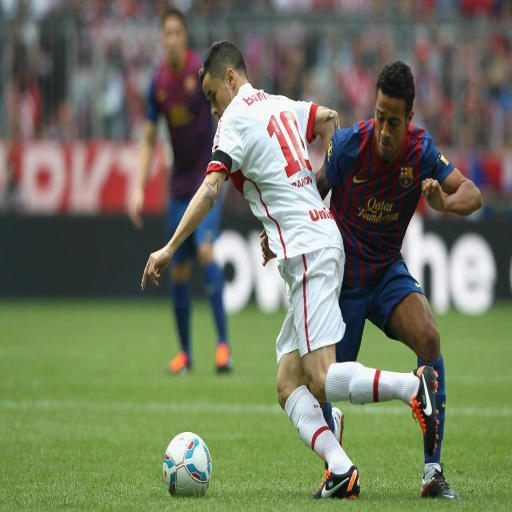

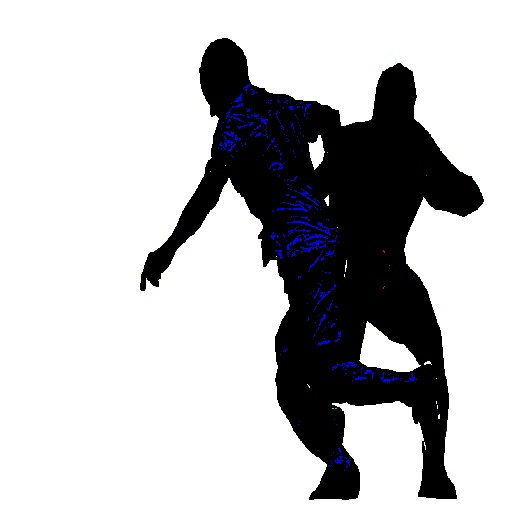

In [11]:
cv2_imshow(x[0] * 255.)
cv2_imshow(y['seg'][0] * 255.)

# Model

In [0]:
# def get_model():
#     in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(in1)
#     conv1 = Dropout(0.2)(conv1)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Dropout(0.2)(conv2)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Dropout(0.2)(conv3)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

#     up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
#     conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
#     conv4 = Dropout(0.2)(conv4)
#     conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

#     up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
#     conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
#     conv5 = Dropout(0.2)(conv5)
#     conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
#     segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv5)

#     model = Model(inputs=[in1], outputs=[segmentation])

#     losses = {'seg': 'binary_crossentropy'
#             }

#     metrics = {'seg': ['acc']
#                 }
#     model.compile(optimizer="adam", loss = losses, metrics=metrics)

#     return model

In [0]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [0]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_white_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_white_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="test"):
            break
        p = np.reshape(x_test[0], (1, 512, 512, 3))
        prediction = self.model.predict(p)

        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        cv2.imwrite(x_img, x_test[0] * 255.)
        cv2.imwrite(y_img, y_test['seg'][0] * 255.)
        cv2.imwrite(predicted_img, prediction[0] * 255.)

In [0]:
model = get_model()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [0]:
model_name = "models/"+"Unet_white_background.h5"

modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

callback_list = [modelcheckpoint, lr_callback, MyCustomCallback()]

history = model.fit_generator(
    keras_generator_train_val_test(batch_size, choice="train"),
    validation_data = keras_generator_train_val_test(batch_size, choice="val"),
    validation_steps = 100,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1, 
    shuffle=True,
    callbacks = callback_list,
)

Instructions for updating:
Please use Model.fit, which supports generators.
intermediate_results_white_background directory already exist
Training: epoch {} begins at 10:26:47.358506
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5584 - acc: 0.3367
Epoch 00001: val_loss improved from inf to 0.50202, saving model to models/Unet_white_background.h5
Training: epoch 0 ends at 10:54:53.827997
100/100 [==============================] - 1688s 17s/step - loss: 0.5584 - acc: 0.3367 - val_loss: 0.5020 - val_acc: 0.1772 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4754 - acc: 0.2868
Epoch 00002: val_loss improved from 0.50202 to 0.44681, saving model to models/Unet_white_background.h5
Training: epoch 1 ends at 11:07:59.693895
100/100 [==============================] - 785s 8s/step - loss: 0.4754 - acc: 0.2868 - val_loss: 0.4468 - val_acc: 0.2771 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.